# 事前準備

In [1]:
# 各種ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
# MNISTデータ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(X_test.shape)
print(X_train[0].dtype)

(60000, 28, 28)
(10000, 28, 28)
uint8


In [3]:
# 全てのピクセルを一列にするため、平滑化を行う
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [4]:
#前処理 画像は0~255で表されるが、機械学習をする上では0~1のfloat型で扱う
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.min(), "-", X_train.max())
print(X_test.min(), "-", X_test.max())

# チャネル軸を増やす
X_train = X_train[:, np.newaxis, :]
X_test = X_test[:, np.newaxis, :]

# 正解ラベル（0から9の整数）をone-hot表現に変換する
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.fit_transform(y_test[:, np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

# データを分割する
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

0.0 - 1.0
0.0 - 1.0
(60000,)
(60000, 10)
float64
(48000, 1, 784)
(12000, 1, 784)
(48000, 10)
(12000, 10)


# 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

ここでは パディング は考えず、ストライド も1に固定します。  
また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。  
この部分の拡張はアドバンス課題とします。  
フォワードプロパゲーションの数式は以下のようになります。  
$a_i$ : 出力される配列のi番目の値  
$F$ : フィルタのサイズ  
$x_{(i+s)}$ : 入力の配列の(i+s)番目の値  
$w_s$ : 重みの配列のs番目の値  
$b$ : バイアス項  
全てスカラーです。  
次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。  
$\alpha$ : 学習率  
$\frac{\partial L}{\partial w_s}$ : $w_s$ に関する損失 $L$ の勾配  
$\frac{\partial L}{\partial b}$ : $b$ に関する損失 $L$ の勾配  
勾配 $\frac{\partial L}{\partial w_s}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。  
$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値  
$N_{out}$ : 出力のサイズ  
前の層に流す誤差の数式は以下です。  
$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値  
ただし、 $j-s<0$ または $j-s>N_{out}-1$ のとき $\frac{\partial L}{\partial a_{(j-s)}} =0$ です。  
全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。  
計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

In [5]:
class XavierInitializer:
    """Xavierの初期値"""
    def W(self, Nin, F):
        """重みの初期化
        :parameters
            Nin (int): 入力のサイズ
            F (int): フィルターサイズ
        :returns
            W (1d-array, (F,)): ランダムに発生させた重み
        """
        return 1.0 / np.sqrt(Nin) * np.random.randn(F)
    
    def B(self, Nin):
        """バイアスの初期化
        :parameters
            Nin (int): 入力のサイズ
        :returns
            B (1d-array, (1,)): ランダムに発生させたバイアス
        """
        return 1.0 / np.sqrt(Nin) * np.random.randn(1)

In [6]:
class SGD:
    """確率的勾配降下法
    :parameters
        lr (float): 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, layer):
        """ある層の重みやバイアスを更新する
        :parameters
            layer (instance): 更新前の層（FC）のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

In [7]:
class SimpleConv1d:
    """シンプルな１次元畳み込み（データ１次元、チャンネル数１、パディングなし、ストライド１）
    :parameters
        n_input (int): 入力サイズ（特徴量の数）
        filter_size (int): 重みのサイズ（正方形と仮定）
        stride (int): ストライド(今回は1)
        padding (int): パディング（今回はなし）
        initializer (class instance): 初期化方法のインスタンス
        optimizer (class instance): 最適化手法のインスタンス
    """
    def __init__(self, n_input, filter_size, stride=1, padding=0, initializer=XavierInitializer(), optimizer=SGD()):
        self.optimizer = optimizer
        # 入出力の形状などを取得
        self.F = filter_size
        self.Nin = n_input
        self.S = stride
        self.P = padding
        self.Nout = self.calc_output_size()  # 出力形状
        # 重みとバイアスの初期化
        self.W = initializer.W(self.Nin, self.F)
        self.B = initializer.B(self.Nin)
    
    def forward(self, X):
        """順伝播
        :parameters
            X (1d-array, (Nin,)): 入力
        :returns
            A (1d-array, (Nout,)): 出力
        """
        A = np.zeros((self.Nout,))
        # 要素ごとに１つずつずらしながら、アダマール積して合計する
        for i in range(self.Nout):
            A[i] = np.sum(X[i:i+self.F] * self.W) + self.B
        
        # Xをbackward用に保持
        self.X = X
        return A
    
    def backward(self, dA):
        """逆伝播
        :parameters
            dA (1d-array, (Nout,)): 出力に関する勾配
        :returns
            dX (1d-array, (Nin,)): 入力に関する勾配
        """
        # dB
        self.dB = np.sum(dA, axis=0, keepdims=True)
        
        # dW （dAを固定して、xをずらしていく）
        self.dW = np.zeros(self.F)
        for i in range(self.F):
            self.dW[i] = np.matmul(self.X[i:i+self.Nout].T, dA)  # X.Tは転置されないけど、後のため。
        
        # dX （wを１つずつずらした（Nout, Nin）行列を作成して、dAとの行列積を計算する）
        tile_W = np.zeros((self.Nout, self.Nin))
        for i in range(self.Nout):
            tile_W[i, i:i+self.F] = self.W  # １つずつずらしながら、代入（空いているところはゼロ）
        dX = np.matmul(dA, tile_W)  # 行列積

        # 勾配をもとに重みとバイアスを更新
        self = self.optimizer.update(self)
        return dX

    def calc_output_size(self):
        return int((self.Nin + 2*self.P - self.F) / self.S + 1)

# 【問題2】1次元畳み込み後の出力サイズの計算

畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。  
パディングやストライドも含めています。この計算を行う関数を作成してください。  
$N_{out}$ : 出力のサイズ（特徴量の数）  
$N_{in}$ : 入力のサイズ（特徴量の数）  
$P$ : ある方向へのパディングの数  
$F$ : フィルタのサイズ  
$S$ : ストライドのサイズ

In [8]:
def calc_output_size(self):
        return int((self.Nin + 2*self.P - self.F) / self.S + 1)

# 【問題3】小さな配列での1次元畳み込み層の実験

次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。  
入力x、重みw、バイアスbを次のようにします。

In [9]:
x = np.array([1, 2, 3, 4], dtype=float)
w = np.array([3, 5, 7], dtype=float)
b = np.array([1], dtype=float)

cnn1 = SimpleConv1d(n_input=len(x), filter_size=len(w))
print("Nin =", cnn1.Nin)
print("F =", cnn1.F)
print("S =", cnn1.S)
print("P =", cnn1.P)
print("Nout =", cnn1.Nout)
print("ランダムに初期値生成した場合の重みとバイアス")
print("W", cnn1.W)
print("B", cnn1.B)
print("重みとバイアスはこっちに変更")
cnn1.W = w
cnn1.B = b
print("W", cnn1.W)
print("B", cnn1.B)

# forward
print("=====forward")
a = cnn1.forward(x)
print("A", a)

# lossがこうだとすると、、、
da = np.array([10, 20], dtype=float)

# backward
print("=====backward")
dx = cnn1.backward(da)
print("dW", cnn1.dW)
print("dB", cnn1.dB)
print("dX", dx)

Nin = 4
F = 3
S = 1
P = 0
Nout = 2
ランダムに初期値生成した場合の重みとバイアス
W [-0.31278988 -0.40323115 -0.23836034]
B [-0.00025004]
重みとバイアスはこっちに変更
W [3. 5. 7.]
B [1.]
=====forward
A [35. 50.]
=====backward
dW [ 50.  80. 110.]
dB [30.]
dX [ 30. 110. 170. 140.]


# 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。

In [10]:
class XavierInitializer2:
    """Xavierの初期値"""
    def W(self, Nin, F, Cin, Cout):
        """重みの初期化
        :parameters
            Nin (int): 入力のサイズ
            F (int): フィルターサイズ
            Cin (int): 入力チャンネル数
            Cout (int): 出力チャンネル数
        :returns
            W (3d-array, (Cout, Cin, F)): ランダムに発生させた重み
        """
        return 1.0 / np.sqrt(Nin) * np.random.randn(Cout, Cin, F)
    
    def B(self, Nin, Cout):
        """バイアスの初期化
        :parameters
            Nin (int): 入力のサイズ
            Cout (int): 出力チャンネル数
        :returns
            B (1d-array, (Cout,)): ランダムに発生させたバイアス
        """
        return 1.0 / np.sqrt(Nin) * np.random.randn(Cout)

In [11]:
class Conv1d:
    """チャンネル数を限定しない１次元畳み込み（データ１次元、パディングなし、ストライド１）
    :parameters
        Nin (int): 入力サイズ（特徴量の数）
        Cin (int): 入力チャンネル数（色の次元の数？）
        Cout (int): 出力チャンネル数（フィルター枚数）
        F (int): フィルター（重み）のサイズ（正方形と仮定）
        S (int): ストライド(今回は1)
        P (int): パディング（今回はなし）
        initializer (class instance): 初期化方法のインスタンス
        optimizer (class instance): 最適化手法のインスタンス
    """
    def __init__(self, Nin, F, Cin, Cout, S=1, P=0, initializer=XavierInitializer2(), optimizer=SGD()):
        self.optimizer = optimizer
        # 入出力の形状などを取得
        self.Nin = Nin
        self.F = F
        self.Cin = Cin
        self.Cout = Cout
        self.S = S
        self.P = P
        self.Nout = self.calc_output_size()  # 出力形状
        # 重みとバイアスの初期化
        self.W = initializer.W(self.Nin, self.F, self.Cin, self.Cout)
        self.B = initializer.B(self.Nin, self.Cout)
    
    def forward(self, X):
        """順伝播
        :parameters
            X (2d-array, (Cin, Nin)): 入力
        :returns
            A (2d-array, (Cout, Nout)): 出力
        """
        # 出力格納用
        A = np.zeros((self.Cout, self.Nout))
        
        # 要素ごとに１つずつずらしながら、アダマール積して合計する
        for i in range(self.Nout):
            # 畳み込みでの、X*W + Bを計算する
            # X(Cin, Nin)のうち、スライスでサイズFだけ取得する。 --> X(Cin, F)
            # X(Cin, F)と、W(Cout, Cin, F)のアダマール積を計算 --> 
            # このとき、XがCout方向にブロードキャストされるので、XW(Cout, Cin, F)になる。
            # (Cin, F)方向に合計するので、np.sum(axis=(1, 2))
            # その結果、np.sum(XW)は(Cout,)となる。これとB(Cout,)との和をとる。
            A[:, i] = np.sum(X[:, i:i+self.F] * self.W, axis=(1, 2)) + self.B

        # Xをbackward用に保持
        self.X = X
        return A
    
    def backward(self, dA):
        """逆伝播
        :parameters
            dA (2d-array, (Cout, Nout)): 出力の勾配
        :returns
            dX (2d-array, (Cin, Nin)): 入力の勾配
        :returns
        """
        # dB(Cout,)
        self.dB = np.sum(dA, axis=1)
        
        # dW(Cout, Cin, F)
        self.dW = np.zeros((self.Cout, self.Cin, self.F))
        for i in range(self.F):
            # X(Cin, Nin) x dA(Cout, Nout)を計算して、dW(Cout, Cin, F)にしたい。
            # スライスして、X(Cin, Nout) x dA.T(Nout, Cout) = XdA(Cin, Cout)
            # これが、F回計算される。
            #print("X[]dA", np.matmul(self.X[:, i:i+self.Nout], dA.T).shape)
            self.dW[:, :, i] = np.matmul(self.X[:, i:i+self.Nout], dA.T).T
        
        # dX(Cin, Nin)
        # W(Cout, Cin, F)
        # dA(Cout, Nout)・ tile_W(Cin, Nout, Nin) = dAW(Cin, Cout, Nin)
        # np.sum(dAW, axis=1).T = dX(Cin, Nin)
        tile_W = np.zeros((self.Cin, self.Cout, self.Nout, self.Nin))
        for i in range(self.Nout):
            tile_W[:, :, i, i:i+self.F] = self.W.transpose(1, 0, 2)  # W(Cout, Cin, F) --> W(Cin, Cout, F)
        dX = np.sum(np.matmul(dA[:, np.newaxis, :], tile_W), axis=(1, 2))  # 行列積
        

        # 勾配をもとに重みとバイアスを更新
        self = self.optimizer.update(self)
        return dX

    def calc_output_size(self):
        return int((self.Nin + 2*self.P - self.F) / self.S + 1)

In [12]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]], dtype=float)
w = np.ones((3, 2, 3), dtype=float)
b = np.array([1, 2, 3], dtype=float)


cnn = Conv1d(Nin=x.shape[1], Cin=x.shape[0], Cout=w.shape[0], F=w.shape[2])
print("Nin =", cnn.Nin)
print("Cin =", cnn.Cin)
print("Cout =", cnn.Cout)
print("F =", cnn.F)
print("S =", cnn.S)
print("P =", cnn.P)
print("Nout =", cnn.Nout)
print("ランダムに初期値生成した場合の重みとバイアス")
print("W", cnn.W)
print("B", cnn.B)
print("重みとバイアスはこっちに変更")
cnn.W = w
cnn.B = b
print("W", cnn.W)
print("B", cnn.B)

# forward
print("=====forward")
a = cnn.forward(x)
print("A", a)


# lossがこうだとすると、、、dxはこうなるはず（dx_true）
da = np.array([[10, 20], [30, 40], [50, 60]], dtype=float)
dx_true = np.array([[90, 210, 210, 120], [90, 210, 210, 120]], dtype=float)

# backward
print("=====backward")
dx = cnn.backward(da)
print("dW", cnn.dW)
print("dB", cnn.dB)
print("dX", dx)

Nin = 4
Cin = 2
Cout = 3
F = 3
S = 1
P = 0
Nout = 2
ランダムに初期値生成した場合の重みとバイアス
W [[[-7.10145978e-01 -9.36557113e-01  2.42480738e-01]
  [-3.06398261e-01  1.98884294e-01 -4.73332275e-01]]

 [[-1.68247262e-01 -5.87483433e-01  4.11674844e-01]
  [-9.86415483e-04  5.61295847e-02 -6.41281042e-01]]

 [[ 4.89812762e-01  1.32009216e-01  5.74506544e-01]
  [-1.94824386e-01  5.17991821e-01 -1.01128735e+00]]]
B [ 1.06731223 -0.63646687 -0.29228512]
重みとバイアスはこっちに変更
W [[[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]]
B [1. 2. 3.]
=====forward
A [[16. 22.]
 [17. 23.]
 [18. 24.]]
=====backward
dW [[[ 50.  80. 110.]
  [ 80. 110. 140.]]

 [[110. 180. 250.]
  [180. 250. 320.]]

 [[170. 280. 390.]
  [280. 390. 500.]]]
dB [ 30.  70. 110.]
dX [[ 90. 210. 210. 120.]
 [ 90. 210. 210. 120.]]


# 【問題5】パディングの実装

In [13]:
class Conv1dPad:
    """チャンネル数を限定しない１次元畳み込み（データ１次元、パディングなし、ストライド１）
    :parameters
        Nin (int): 入力サイズ（特徴量の数）
        Cin (int): 入力チャンネル数（色の次元の数？）
        Cout (int): 出力チャンネル数（フィルター枚数）
        F (int): フィルター（重み）のサイズ（正方形と仮定）
        S (int): ストライド(今回は1)
        P (int): パディング（今回はなし）
        initializer (class instance): 初期化方法のインスタンス
        optimizer (class instance): 最適化手法のインスタンス
    """
    def __init__(self, Cout, F, S=1, P=0, pad_method="constant", initializer=XavierInitializer2(), optimizer=SGD()):
        # 重み初期化方法・最適化手法
        self.initializer = initializer
        self.optimizer = optimizer
        # フィルター形状・畳み込みの方法（stride, padding）などを取得
        self.Cout = Cout
        self.F = F
        self.S = S
        self.P = P
        self.pad_method = pad_method
        # 重みとバイアス
        self.W = None
        self.B = None
    
    def forward(self, X):
        """順伝播
        :parameters
            X (2d-array, (Cin, Nin)): 入力
        :returns
            A (2d-array, (Cout, Nout)): 出力
        """
        # 形状取得
        # Cout, F, S, Pはインスタンス化した時に取得済み
        self.Cin = X.shape[0]  # 入力チャンネル数
        self.Nin = X.shape[1]  # 入力特徴量数
        self.Nout = self.calc_output_size()  # 出力サイズ（出力特徴量数）
        print("Nout", self.Nout)
        
        # パディング
        if self.P > 0:
            self.X = np.pad(X, [(0, 0), (self.P, self.P)], self.pad_method)
            print("padded X\n", self.X)
        else:
            self.X = X.copy()

        # 重みとバイアスの初期化
        #self.W = self.initializer.W(self.Nin, self.F, self.Cin, self.Cout)
        #self.B = self.initializer.B(self.Nin, self.Cout)
        
        # 出力格納用
        A = np.zeros((self.Cout, self.Nout))
        
        # 要素ごとに１つずつずらしながら、アダマール積して合計する
        for i in range(self.Nout):
            # 畳み込み： X*W + Bを計算する
            # X(Cin, Nin)のうち、スライスでサイズFだけ取得する。 --> X(Cin, F)
            # X(Cin, F)と、W(Cout, Cin, F)のアダマール積を計算 --> 
            # このとき、XがCout方向にブロードキャストされるので、XW(Cout, Cin, F)になる。
            # (Cin, F)方向に合計するので、np.sum(axis=(1, 2))
            # その結果、np.sum(XW)は(Cout,)となる。これとB(Cout,)との和をとる。
            A[:, i] = np.sum(self.X[:, i:i+self.F] * self.W, axis=(1, 2)) + self.B
        return A
    
    def backward(self, dA):
        """逆伝播
        :parameters
            dA (2d-array, (Cout, Nout)): 出力の勾配
        :returns
            dX (2d-array, (Cin, Nin)): 入力の勾配
        :returns
        """
        # dB(Cout,)
        self.dB = np.sum(dA, axis=1)
        
        # dW(Cout, Cin, F)
        self.dW = np.zeros((self.Cout, self.Cin, self.F))
        for i in range(self.F):
            # X(Cin, Nin) x dA(Cout, Nout)を計算して、dW(Cout, Cin, F)にしたい。
            # スライスして、X(Cin, Nout) x dA.T(Nout, Cout) = XdA(Cin, Cout)
            # これが、F回計算される。
            #print(self.X[:, i:i+self.Nout].shape)
            #print(dA.T.shape)
            self.dW[:, :, i] = np.matmul(self.X[:, i:i+self.Nout], dA.T).T
        
        # dX(Cin, Nin)を求める部分
        # 最初に、W(Cout, Cin, F)からtile_W(Cin, Cout, Nout, Nin)を作る
        # 一つずつずらしながら、Wをタイルする。
        tile_W = np.zeros((self.Cin, self.Cout, self.Nout, self.Nin + 2*self.P))
        for i in range(self.Nout):
            tile_W[:, :, i, i:i+self.F] = self.W.transpose(1, 0, 2)  # W(Cout, Cin, F) --> W(Cin, Cout, F)
        # dA(Cout, Nout)のまま、行列計算を行うと、
        # dA(Cout, Nout) ・ tile_W(Cin, Cout, Nout, Nin) = dAW(Cin, Cout, Cout, Nin)になるので、
        # dA(Cout, 1, Nout)に変形してから
        # dA(Cout, 1, Nout) ・ tile_W(Cin, Cout, Nout, Nin) = dAW(Cin, Cout, 1, Nin)とする。
        # np.sum(dAW, axis=(1, 2))で、dX(Cin, Nin)となる。
        dX = np.sum(np.matmul(dA[:, np.newaxis, :], tile_W), axis=(1, 2))
        
        # パディングした部分を削除する
        if self.P > 0:
            dX = dX[:, self.P:-self.P]
        
        # 勾配をもとに重みとバイアスを更新
        self = self.optimizer.update(self)
        return dX

    def calc_output_size(self):
        return int((self.Nin + 2*self.P - self.F) / self.S + 1)

In [14]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]], dtype=float)
w = np.ones((3, 2, 3), dtype=float)
b = np.array([1, 2, 3], dtype=float)


#cnn = Conv1d(Nin=x.shape[1], Cin=x.shape[0], Cout=w.shape[0], F=w.shape[2])
n_pad = 2
cnn = Conv1dPad(Cout=w.shape[0], F=w.shape[2], S=1, P=n_pad)
print("Cout =", cnn.Cout)
print("F =", cnn.F)
print("S =", cnn.S)
print("P =", cnn.P)
print("重みとバイアスはこっちに変更")
cnn.W = w
cnn.B = b
print("W", cnn.W)
print("B", cnn.B)

# forward
print("=====forward")
a = cnn.forward(x)
print("A", a)


# lossがこうだとすると、、、dxはこうなるはず（dx_true）
if n_pad == 0:
    da = np.array([[10, 10], [20, 40], [30, 10]], dtype=float)
    dx_true = np.array([[90, 210, 210, 120], [90, 210, 210, 120]], dtype=float)
elif n_pad == 1:
    da = np.array([[10, 10, 10, 10],
                   [20, 40, 20, 40],
                   [30, 10, 30, 10]], dtype=float)
elif n_pad == 2:
    da = np.array([[10, 10, 10, 10, 10, 10],
                   [20, 40, 20, 40, 20, 40],
                   [30, 10, 30, 10, 30, 10]], dtype=float)

# backward
print("=====backward")
dx = cnn.backward(da)
print("dW", cnn.dW)
print("dB", cnn.dB)
print("dX", dx)

Cout = 3
F = 3
S = 1
P = 2
重みとバイアスはこっちに変更
W [[[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]]
B [1. 2. 3.]
=====forward
Nout 6
padded X
 [[0. 0. 1. 2. 3. 4. 0. 0.]
 [0. 0. 2. 3. 4. 5. 0. 0.]]
A [[ 4.  9. 16. 22. 17. 10.]
 [ 5. 10. 17. 23. 18. 11.]
 [ 6. 11. 18. 24. 19. 12.]]
=====backward
dW [[[100. 100. 100.]
  [140. 140. 140.]]

 [[320. 280. 320.]
  [440. 400. 440.]]

 [[180. 220. 180.]
  [260. 300. 260.]]]
dB [ 60. 180. 120.]
dX [[180. 180. 180. 180.]
 [180. 180. 180. 180.]]


# 【問題6】ミニバッチへの対応

ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。  
Conv1dクラスを複数のデータが同時に計算できるように変更してください。

In [15]:
class HeInitializer:
    """Heの初期値"""
    def W(self, Nin, F, Cin, Cout):
        """重みの初期化
        :parameters
            Nin (int): 入力のサイズ
            F (int): フィルターサイズ
            Cin (int): 入力チャンネル数
            Cout (int): 出力チャンネル数
        :returns
            W (3d-array, (Cout, Cin, F)): ランダムに発生させた重み
        """
        return np.sqrt(2.0 / (Cin*Nin)) * np.random.randn(Cout, Cin, F)
    
    def B(self, Nin, Cin, Cout):
        """バイアスの初期化
        :parameters
            Nin (int): 入力のサイズ
            Cout (int): 出力チャンネル数
        :returns
            B (1d-array, (Cout,)): ランダムに発生させたバイアス
        """
        return np.sqrt(2.0 / (Cin*Nin)) * np.random.randn(Cout)

In [16]:
class SGD:
    """確率的勾配降下法
    :parameters
        lr (float): 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, layer):
        """ある層の重みやバイアスを更新する
        :parameters
            layer (instance): 更新前の層（FC）のインスタンス
        """
        layer.W -= self.lr * layer.dW / layer.Ndata
        layer.B -= self.lr * layer.dB / layer.Ndata
        return layer

In [17]:
class Conv1dBatch:
    """チャンネル数を限定しない１次元畳み込み（データ１次元、パディングなし、ストライド１）
    :parameters
        Nin (int): 入力サイズ（特徴量の数）
        Cin (int): 入力チャンネル数（色の次元の数？）
        Cout (int): 出力チャンネル数（フィルター枚数）
        F (int): フィルター（重み）のサイズ（正方形と仮定）
        S (int): ストライド(今回は1)
        P (int): パディング（今回はなし）
        initializer (class instance): 初期化方法のインスタンス
        optimizer (class instance): 最適化手法のインスタンス
    """
    def __init__(self, Cout, F, S=1, P=0, pad_method="constant", initializer=HeInitializer(), optimizer=SGD()):
        # 重み初期化方法・最適化手法
        self.initializer = initializer
        self.optimizer = optimizer
        # フィルター形状・畳み込みの方法（stride, padding）などを取得
        self.Cout = Cout
        self.F = F
        self.S = S
        self.P = P
        self.pad_method = pad_method
        # 重みとバイアス
        self.W = None
        self.B = None
    
    def forward(self, X):
        """順伝播
        :parameters
            X (3d-array, (Ndata, Cin, Nin)): 入力
        :returns
            A (3d-array, (Ndata, Cout, Nout)): 出力
        """
        # データ数・形状等の取得
        # Cout, F, S, Pはインスタンス化した時に取得済み
        self.Ndata = X.shape[0]  # データ数
        self.Cin = X.shape[1]  # 入力チャンネル数
        self.Nin = X.shape[2]  # 入力特徴量数
        self.Nout = self.calc_output_size()  # 出力サイズ（出力特徴量数）
        print("Nout", self.Nout)
        
        # パディング
        if self.P > 0:
            self.X = np.pad(X, [(0, 0), (0, 0), (self.P, self.P)], self.pad_method)
            print("padded X\n", self.X)
        else:
            self.X = X.copy()

        # 重みとバイアスの初期化（テスト時はコメントアウトする）
        #self.W = self.initializer.W(self.Nin, self.F, self.Cin, self.Cout)
        #self.B = self.initializer.B(self.Nin, self.Cout)
        
        # 出力格納用
        A = np.zeros((self.Ndata, self.Cout, self.Nout))

        # 要素ごとに１つずつずらしながら、アダマール積して合計する
        for i in range(self.Nout):
            # 畳み込み： X*W + Bを計算する
            # X(Ndata, Cin, Nin)のうち、スライスでサイズFだけ取得する。 --> X(Ndata, Cin, F)
            # X(Ndata, Cin, F)と、W(Cout, Cin, F)のアダマール積を計算するが、
            # このとき、XをCout方向にブロードキャストしたいので、newaxisで X(Ndata, 1, Cin, F)とする。
            # これで、XW(Ndata, Cout, Cin, F)になる。
            XW = self.X[:, np.newaxis, :, i:i+self.F] * self.W
            
            # XWを(Cin, F)方向に合計するので、np.sum(XW, axis=(1, 2))
            # その結果、np.sum(XW)は(Cout,)となる。これとB(Cout,)との和をとる。
            A[:, :, i] = np.sum(XW, axis=(1, 2)) + self.B
        return A
    
    def backward(self, dA):
        """逆伝播
        :parameters
            dA (3d-array, (Ndata, Cout, Nout)): 出力の勾配
        :returns
            dX (3d-array, (Ndata, Cin, Nin)): 入力の勾配
        :returns
        """
        # dB(Cout,)
        self.dB = np.sum(dA, axis=(0, 2))
        
        # dW(Cout, Cin, F)
        self.dW = np.zeros((self.Cout, self.Cin, self.F))
        for i in range(self.F):
            # X(Ndata, Cin, Nin) x dA(Ndata, Cout, Nout)を計算して、dW(Cout, Cin, F)にしたい。
            # スライスして、X[](Ndata, Cin, Nout) x dA(Ndata, Nout, Cout) = XdA(Ndata, Cin, Cout)
            XdA = np.matmul(self.X[:, :, i:i+self.Nout], dA.transpose(0, 2, 1))
            
            # これをNdata方向に合計すると、sumXdA(Cin, Cout)となる。
            sumXdA = np.sum(XdA, axis=0)
            
            # dW(Cout, Cin, F)に格納するために、XdA(Cin, Cout)を転置して、(Cout, Cin)にする。
            self.dW[:, :, i] = sumXdA.T
        
        # dX(Ndata, Cin, Nin)を求める部分
        # 最初に、W(Cout, Cin, F)からtile_W(Cin, Cout, Nout, Nin)を作る
        # 一つずつずらしながら、Wをタイルする。
        tile_W = np.zeros((self.Cin, self.Cout, self.Nout, self.Nin + 2*self.P))
        for i in range(self.Nout):
            tile_W[:, :, i, i:i+self.F] = self.W.transpose(1, 0, 2)  # W(Cout, Cin, F) --> W(Cin, Cout, F)

        # dA(Ndata, Cout, Nout)のまま、行列計算を行うと、
        # dA(Ndata, Cout, Nout) ・ tile_W(Cin, Cout, Nout, Nin) = dAW(Ndata, Cin, Cout, Cout, Nin)になるので、
        # dA(Ndata, 1, Cout, 1, Nout)に変形してから
        # dA(Ndata, 1, Cout, 1, Nout) ・ tile_W(Cin, Cout, Nout, Nin) = dAW(Ndata, Cin, Cout, 1, Nin)とする。
        dAW = np.matmul(dA[:, np.newaxis, :, np.newaxis, :], tile_W)  # (Ndata, Cin, Cout, 1, Nin)
        
        # (Cout, 1)方向で合計をとると、np.sum(dAW, axis=(2, 3))
        # その結果、dX(Ndata, Cin, Nin)となる。
        dX = np.sum(dAW, axis=(2, 3))
        
        # パディングした部分を削除する
        if self.P > 0:
            dX = dX[:, :, self.P:-self.P]
        
        # 勾配をもとに重みとバイアスを更新
        self = self.optimizer.update(self)
        return dX

    def calc_output_size(self):
        return int((self.Nin + 2*self.P - self.F) / self.S + 1)

In [18]:
# X(Ndata, Cin, Nout) x dA(Ndata, Nout, Cout)
x = np.ones((5, 2, 6))
da = np.ones((5, 6, 3))
c = np.matmul(x, da)
print(c.shape)

# dA(Ndata, Cout, Nout), tile_W(Cin, Cout, Nout, Nin)
da = np.ones((5, 3, 6))
tw = np.ones((2, 3, 6, 8))
print(da[:, np.newaxis, :, np.newaxis, :].shape)
print(tw.shape)
dx = np.matmul(da[:, np.newaxis, :, np.newaxis, :], tw)
print(dx.shape)

(5, 2, 3)
(5, 1, 3, 1, 6)
(2, 3, 6, 8)
(5, 2, 3, 1, 8)


In [19]:
x = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]],
              [[2, 3, 4, 5], [3, 4, 5, 6]],
              [[3, 4, 5, 6], [4, 5, 6, 7]],
              [[4, 5, 6, 7], [5, 6, 7, 8]],
              [[5, 6, 7, 8], [6, 7, 8, 9]],
             ], dtype=float)
print(x.shape)
w = np.ones((3, 2, 3), dtype=float)
b = np.array([1, 2, 3], dtype=float)

#cnn = Conv1d(Nin=x.shape[1], Cin=x.shape[0], Cout=w.shape[0], F=w.shape[2])
n_pad = 2
cnn = Conv1dBatch(Cout=w.shape[0], F=w.shape[2], S=1, P=n_pad)
print("Cout =", cnn.Cout)
print("F =", cnn.F)
print("S =", cnn.S)
print("P =", cnn.P)
print("重みとバイアスはこっちに変更")
cnn.W = w
cnn.B = b
print("W", cnn.W)
print("B", cnn.B)

# forward
print("=====forward")
a = cnn.forward(x)
print("A", a)


# lossがこうだとすると、、、dxはこうなるはず（dx_true）
if n_pad == 0:
    da = np.array([[[10, 10], [20, 40], [30, 10]]], dtype=float)
    dx_true = np.array([[90, 210, 210, 120], [90, 210, 210, 120]], dtype=float)
elif n_pad == 1:
    da = np.array([[10, 10, 10, 10],
                   [20, 40, 20, 40],
                   [30, 10, 30, 10]], dtype=float)
elif n_pad == 2:
    da = np.array([[[10, 10, 10, 10, 10, 10], [20, 40, 20, 40, 20, 40], [30, 10, 30, 10, 30, 10]],
                   [[10, 10, 10, 10, 10, 10], [20, 40, 20, 40, 20, 40], [30, 10, 30, 10, 30, 10]],
                   [[10, 10, 10, 10, 10, 10], [20, 40, 20, 40, 20, 40], [30, 10, 30, 10, 30, 10]],
                   [[10, 10, 10, 10, 10, 10], [20, 40, 20, 40, 20, 40], [30, 10, 30, 10, 30, 10]],
                   [[10, 10, 10, 10, 10, 10], [20, 40, 20, 40, 20, 40], [30, 10, 30, 10, 30, 10]],
                  ], dtype=float)

print("dA", da.shape)
# backward
print("=====backward")
dx = cnn.backward(da)
print("dW", cnn.dW)
print("dB", cnn.dB)
print("dX", dx)

(5, 2, 4)
Cout = 3
F = 3
S = 1
P = 2
重みとバイアスはこっちに変更
W [[[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]]
B [1. 2. 3.]
=====forward
Nout 6
padded X
 [[[0. 0. 1. 2. 3. 4. 0. 0.]
  [0. 0. 2. 3. 4. 5. 0. 0.]]

 [[0. 0. 2. 3. 4. 5. 0. 0.]
  [0. 0. 3. 4. 5. 6. 0. 0.]]

 [[0. 0. 3. 4. 5. 6. 0. 0.]
  [0. 0. 4. 5. 6. 7. 0. 0.]]

 [[0. 0. 4. 5. 6. 7. 0. 0.]
  [0. 0. 5. 6. 7. 8. 0. 0.]]

 [[0. 0. 5. 6. 7. 8. 0. 0.]
  [0. 0. 6. 7. 8. 9. 0. 0.]]]
A [[[ 1.  1. 10. 16. 22. 28.]
  [ 2. 11. 17. 23. 29.  2.]
  [12. 18. 24. 30.  3.  3.]]

 [[ 1.  1. 16. 22. 28. 34.]
  [ 2. 17. 23. 29. 35.  2.]
  [18. 24. 30. 36.  3.  3.]]

 [[ 1.  1. 22. 28. 34. 40.]
  [ 2. 23. 29. 35. 41.  2.]
  [24. 30. 36. 42.  3.  3.]]

 [[ 1.  1. 28. 34. 40. 46.]
  [ 2. 29. 35. 41. 47.  2.]
  [30. 36. 42. 48.  3.  3.]]

 [[ 1.  1. 34. 40. 46. 52.]
  [ 2. 35. 41. 47. 53.  2.]
  [36. 42. 48. 54.  3.  3.]]]
dA (5, 3, 6)
=====backward
dW [[[ 900.  900.  900.]
  [1100. 1100. 1100.]]

 [[2800. 2600. 2800.]

# 【問題7】任意のストライド数

ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

In [20]:
class HeInitializerForConv1d:
    """Heの初期値"""
    def W(self, Nin, F, Cin, Cout):
        """重みの初期化
        :parameters
            Nin (int): 入力のサイズ
            F (int): フィルターサイズ
            Cin (int): 入力チャンネル数
            Cout (int): 出力チャンネル数
        :returns
            W (3d-array, (Cout, Cin, F)): ランダムに発生させた重み
        """
        return np.sqrt(2.0 / (Cin*Nin)) * np.random.randn(Cout, Cin, F)
    
    def B(self, Nin, Cin, Cout):
        """バイアスの初期化
        :parameters
            Nin (int): 入力のサイズ
            Cout (int): 出力チャンネル数
        :returns
            B (1d-array, (Cout,)): ランダムに発生させたバイアス
        """
        return np.sqrt(2.0 / (Cin*Nin)) * np.random.randn(Cout)

class HeInitializerForAffine:
    """Heの初期値"""
    def W(self, n_nodes1, n_nodes2):
        """重みの初期化
        :parameters
            n_nodes1 (int): 前の層のノード数
            n_nodes2 (int): 後の層のノード数
        :returns
            W (2d-array, (n_nodes1, n_nodes2)): ランダムに発生させた重み
        """
        return np.sqrt(2.0 / n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes1, n_nodes2):
        """バイアスの初期化
        :parameters
            n_nodes2 (int): 後の層のノード数
        :returns
            B (1d-array, (n_nodes2, )): ランダムに発生させたバイアス
        """
        return np.sqrt(2.0 / n_nodes1) * np.random.randn(1, n_nodes2)

In [21]:
class Conv1d:
    """チャンネル数を限定しない１次元畳み込み（データ１次元、パディングなし、ストライド１）
    :parameters
        Nin (int): 入力サイズ（特徴量の数）
        Cin (int): 入力チャンネル数（色の次元の数？）
        Cout (int): 出力チャンネル数（フィルター枚数）
        F (int): フィルター（重み）のサイズ（正方形と仮定）
        S (int): ストライド(今回は1)
        P (int): パディング（今回はなし）
        initializer (class instance): 初期化方法のインスタンス
        optimizer (class instance): 最適化手法のインスタンス
    """
    def __init__(self, Cout, F, S=1, P=0, pad_method="constant", initializer=HeInitializerForConv1d(), optimizer=SGD()):
        # 重み初期化方法・最適化手法
        self.initializer = initializer
        self.optimizer = optimizer
        # フィルター形状・畳み込みの方法（stride, padding）などを取得
        self.Cout = Cout
        self.F = F
        self.S = S
        self.P = P
        self.pad_method = pad_method
        # 重みとバイアス
        self.W = None
        self.B = None
        self.is_first_forward = True
    
    def forward(self, X):
        """順伝播
        :parameters
            X (3d-array, (Ndata, Cin, Nin)): 入力
        :returns
            A (3d-array, (Ndata, Cout, Nout)): 出力
        """
        # データ数・形状等の取得
        # Cout, F, S, Pはインスタンス化した時に取得済み
        self.Ndata = X.shape[0]  # データ数
        self.Cin = X.shape[1]  # 入力チャンネル数
        self.Nin = X.shape[2]  # 入力特徴量数
        self.Nout = self.calc_output_size()  # 出力サイズ（出力特徴量数）
        
        # パディング
        self.X = np.pad(X, [(0, 0), (0, 0), (self.P, self.P)], self.pad_method)

        # １回目のforwardでは、重みとバイアスを初期化する（テスト時はコメントアウトする）
        if self.is_first_forward:
            self.W = self.initializer.W(self.Nin, self.F, self.Cin, self.Cout)
            self.B = self.initializer.B(self.Nin, self.Cin, self.Cout)
            self.is_first_forward = False
        
        # 出力格納用
        A = np.zeros((self.Ndata, self.Cout, self.Nout))

        # 要素ごとにSずつずらしながら、アダマール積して合計する
        for i in range(self.Nout):
            # 畳み込み： X*W + Bを計算する
            # X(Ndata, Cin, Nin)のうち、スライスでサイズFだけ取得する。 --> X(Ndata, Cin, F)
            # X(Ndata, Cin, F)と、W(Cout, Cin, F)のアダマール積を計算するが、
            # このとき、Xを、WのCout方向にブロードキャストしたいので、newaxisで X(Ndata, 1, Cin, F)とする。
            # これで、XW(Ndata, Cout, Cin, F)になる。
            p = i * self.S
            XW = self.X[:, np.newaxis, :, p:p+self.F] * self.W
            
            # XWを(Cin, F)方向に合計する
            # その結果、np.sum(XW)は(Ndata, Cout)となる。
            # これとB(Cout,)との和をとると、ブロードキャストされて、(Ndata, Cout)となる。
            A[:, :, i] = np.sum(XW, axis=(2, 3)) + self.B
        return A
    
    def backward(self, dA):
        """逆伝播
        :parameters
            dA (3d-array, (Ndata, Cout, Nout)): 出力の勾配
        :returns
            dX (3d-array, (Ndata, Cin, Nin)): 入力の勾配
        :returns
        """
        # dB(Cout,)
        self.dB = np.sum(dA, axis=(0, 2))
        
        # dW(Cout, Cin, F)
        self.dW = np.zeros((self.Cout, self.Cin, self.F))
        for i in range(self.F):
            # X(Ndata, Cin, Nin) x dA(Ndata, Cout, Nout)を計算して、dW(Cout, Cin, F)にしたい。
            # スライスして、X[](Ndata, Cin, Nout) x dA(Ndata, Nout, Cout) = XdA(Ndata, Cin, Cout)
            XdA = np.matmul(self.X[:, :, i:i+self.S*self.Nout:self.S], dA.transpose(0, 2, 1))
            
            # これをNdata方向に合計すると、sumXdA(Cin, Cout)となる。
            sumXdA = np.sum(XdA, axis=0)
            
            # dW(Cout, Cin, F)に格納するために、XdA(Cin, Cout)を転置して、(Cout, Cin)にする。
            self.dW[:, :, i] = sumXdA.T
        
        # dX(Ndata, Cin, Nin)を求める部分
        # 最初に、W(Cout, Cin, F)からtile_W(Cin, Cout, Nout, Nin)を作る
        # 一つずつずらしながら、Wをタイルする。
        tile_W = np.zeros((self.Cin, self.Cout, self.Nout, self.Nin + 2*self.P))
        for i in range(self.Nout):
            p = i * self.S
            tile_W[:, :, i, p:p+self.F] = self.W.transpose(1, 0, 2)  # W(Cout, Cin, F) --> W(Cin, Cout, F)

        # dA(Ndata, Cout, Nout) を tile_W(Cin, Cout, Nout, Nin+2P) と積和する
        # dA     (Ndata,   1, Cout, Nout,      1)
        # tile_W (    1, Cin, Cout, Nout, Nin+2P)
        # アダマール積すると、
        # dAW    (Ndata, Cin, Cout, Nout, Nin+2P)
        dAW = dA[:, np.newaxis, :, :, np.newaxis] * tile_W[np.newaxis, ...]
        
        # dAW(Ndata, Cin, Cout, Nout, Nin+2P)のうち、(Cout, Nout)方向で合計をとる
        # その結果、dX(Ndata, Cin, Nin+2P)となる。
        dX = np.sum(dAW, axis=(2, 3))
        
        # パディングした部分を削除して
        # dX(Ndata, Cin, Nin+2P) --> dX(Ndata, Cin, Nin)とする。
        if self.P > 0:
            dX = dX[:, :, self.P:-self.P]
        
        # 勾配をもとに重みとバイアスを更新
        self = self.optimizer.update(self)
        return dX

    def calc_output_size(self):
        return (self.Nin + 2*self.P - self.F) // self.S + 1

In [22]:
x = np.ones((5, 2, 7))
"""
x = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]],
              [[2, 3, 4, 5], [3, 4, 5, 6]],
              [[3, 4, 5, 6], [4, 5, 6, 7]],
              [[4, 5, 6, 7], [5, 6, 7, 8]],
              [[5, 6, 7, 8], [6, 7, 8, 9]],
             ], dtype=float)
"""
print("X", x.shape)
w = np.ones((3, 2, 3), dtype=float)
b = np.array([1, 2, 3], dtype=float)

n_pad = 1
n_stride = 2
cnn = Conv1d(Cout=w.shape[0], F=w.shape[2], S=n_stride, P=n_pad)
print("Cout =", cnn.Cout)
print("F =", cnn.F)
print("S =", cnn.S)
print("P =", cnn.P)
print("重みとバイアスはこっちに変更")
cnn.W = w
cnn.B = b
print("W", cnn.W)
print("B", cnn.B)

# forward
print("=====forward")
a = cnn.forward(x)
print("A", a.shape)

# da
da = np.array([[[10, 10, 10, 10], [20, 40, 20, 40], [30, 10, 30, 10]],
               [[10, 10, 10, 10], [20, 40, 20, 40], [30, 10, 30, 10]],
               [[10, 10, 10, 10], [20, 40, 20, 40], [30, 10, 30, 10]],
               [[10, 10, 10, 10], [20, 40, 20, 40], [30, 10, 30, 10]],
               [[10, 10, 10, 10], [20, 40, 20, 40], [30, 10, 30, 10]],
              ], dtype=float)
print("dA", da.shape)
# backward
print("=====backward")
dx = cnn.backward(da)
print("dW", cnn.dW)
print("dB", cnn.dB)
print("dX", dx)

X (5, 2, 7)
Cout = 3
F = 3
S = 2
P = 1
重みとバイアスはこっちに変更
W [[[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]]
B [1. 2. 3.]
=====forward
A (5, 3, 4)
dA (5, 3, 4)
=====backward
dW [[[150. 200. 150.]
  [150. 200. 150.]]

 [[500. 600. 400.]
  [500. 600. 400.]]

 [[250. 400. 350.]
  [250. 400. 350.]]]
dB [200. 600. 400.]
dX [[[  2.76169381   6.79854078  -2.72256609  -5.60055129   2.76169381
     6.79854078  -2.72256609]
  [-14.320249    -3.99400275  -9.34516671  -7.75242074 -14.320249
    -3.99400275  -9.34516671]]

 [[  2.76169381   6.79854078  -2.72256609  -5.60055129   2.76169381
     6.79854078  -2.72256609]
  [-14.320249    -3.99400275  -9.34516671  -7.75242074 -14.320249
    -3.99400275  -9.34516671]]

 [[  2.76169381   6.79854078  -2.72256609  -5.60055129   2.76169381
     6.79854078  -2.72256609]
  [-14.320249    -3.99400275  -9.34516671  -7.75242074 -14.320249
    -3.99400275  -9.34516671]]

 [[  2.76169381   6.79854078  -2.72256609  -5.60055129   2.76

# 【問題8】学習と推定

これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。  
出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。  
その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。  
画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [23]:
class GetMiniBatch:
    """ミニバッチを取得するイテレータ
    :parameters
        X (2d-array, (n_samples, n_features)): 訓練データ
        y (1d-array, (n_samples, 1)): 正解値
        batch_size (int): バッチサイズ
        seed (int): 乱数のシード
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [24]:
class ReLU:
    """rectified linear unit関数（活性化関数）"""
    def forward(self, A):
        self.is_positive = A > 0
        Z = self.is_positive * A
        return Z
    
    def backward(self, dZ):
        if dZ.shape == self.is_positive.shape:
            dA = self.is_positive * dZ
        else:
            dA = self.is_positive * dZ[:, np.newaxis, :]
        return dA

In [25]:
class Softmax:
    """softmax関数
    backwardは交差エントロピー誤差関数と合わせて計算する
    """
    def forward(self, A):
        y_pred = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
        # backward用にy_predを保持
        self.y_pred = y_pred
        return y_pred
    
    def backward(self, y_true):
        dA = self.y_pred - y_true
        return dA

In [26]:
class FC:
    """ノード数n_nodes1からn_nodes2への全結合層
    :parameters
        n_node1 (int): 前層のノード数
        n_node2 (int): 後層のノード数
        initializer (class instance): 初期化方法のインスタンス
        optimizer (class instance): 最適化手法のインスタンス
    """
    def __init__(self, n_nodes2, initializer=HeInitializerForAffine(), optimizer=SGD()):
        self.initializer = initializer
        self.optimizer = optimizer
        self.n_nodes2 = n_nodes2
        self.is_first_forward = True
    
    def forward(self, X):
        """順伝播
        :parameters
            X (2d-array, (batch_size, n_nodes1)): 入力
        :returns
            A (2d-array, (batch_size, n_nodes2)): 出力
        """
        # チャネル数が残っているときは削除する
        if X.ndim > 2:
            X = np.squeeze(X, 1)

        # 形状取得
        n_nodes1 = X.shape[1]
        n_nodes2 = self.n_nodes2
        
        # 初めてforwardを実行するときは、重みとバイアスを初期化
        if self.is_first_forward:
            self.W = self.initializer.W(n_nodes1, n_nodes2)
            self.B = self.initializer.B(n_nodes1, n_nodes2)
            self.is_first_forward = False

        # 線形結合
        A = np.matmul(X, self.W) + self.B
        
        # backward用にXを保持
        self.X = X
        self.Ndata = X.shape[0]
        return A
    
    def backward(self, dA):
        """逆伝播
        :parameters
            dA (2d-array, (batch_size, n_nodes2)): 後層から戻ってきた勾配
        :returns
            dZ (2d-array, (batch_size, n_nodes1)): 前層に送る勾配
        """
        self.dB = np.sum(dA, axis=0, keepdims=True)
        self.dW = np.matmul(self.X.T, dA)
        dX = np.matmul(dA, self.W.T)
        # 勾配をもとに重みとバイアスを更新
        self = self.optimizer.update(self)
        return dX

In [27]:
class CNN1dClassifier():
    """Convolution Neural Network Classifier
    :attributes
        layers (list of instances): 各層のインスタンスを並べたリスト
        n_epoch (int): 繰り返すエポック数
        batch_size (int): ミニバッチのデータ数
        plot_interval (int): 損失関数を記録する間隔
        epoch_interval (int): 何epochごとにprintするか
        loss (list): 損失関数の推移（訓練データ）
        lossval (list): 損失関数の推移（検証データ）
        verbose (bool): 学習過程を出力する場合はTrue
    """
    def __init__(self, layers, n_epoch=10, batch_size=20, plot_interval=1, verbose=True, epoch_interval=1):
        self.layers = layers
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.plot_interval = plot_interval
        self.epoch_interval = epoch_interval
        self.verbose = verbose
        self.loss = []
        self.loss_val = []
    
    def fit(self, X, y, X_val=None, y_val=None):
        """ニューラルネットワーク分類器を学習する。
        :parameters
            X (2d-array, (n_samples, n_features)): 訓練データの特徴量
            y (2d-array, (n_samples, n_classes)): 訓練データの正解値（One-hot）
            X_val (2d-array, (n_samples, n_features)): 検証データの特徴量
            y_val (2d-array, (n_samples, n_classes)): 検証データの正解値（One-hot）
            optimizer (instance): 最適化手法のインスタンス
        """
        # データチェック
        self.n_features = X.shape[1]
        self.n_output = y.shape[1]

        # 学習
        for epoch in range(self.n_epoch):
            # エポックごとに乱数を変えて、ミニバッチを取得する
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=epoch)
            
            # ミニバッチごとに学習をすすめる。
            for mini_X_train, mini_y_train in get_mini_batch:
                # forward
                data = mini_X_train
                for layer in self.layers:
                    data = layer.forward(data)

                # backward
                grad = mini_y_train
                for layer in reversed(self.layers):
                    grad = layer.backward(grad)
                
            # 損失（交差エントロピー誤差）を計算して保持
            y_pred = self.predict_proba(X)  # 分類カテゴリーごとの確率を計算
            L = self.cross_entropy_error(y_pred, y)
            self.loss.append(L)
            # 検証データありの場合はそちらの損失も保持
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict_proba(X_val)  # 分類カテゴリーごとの確率を計算
                L_val = self.cross_entropy_error(y_pred_val, y_val)
                self.loss_val.append(L_val)

            # 学習過程の出力（エポックごと）
            if self.verbose and (epoch % self.epoch_interval == 0):
                str_loss = "Epoch" + str(epoch).rjust(4)
                str_loss += "\tLoss {:.5f}".format(self.loss[-1])
                if len(self.loss_val) != 0:
                    str_loss += "\tLoss_valid {:.5f}".format(self.loss_val[-1])
                print(str_loss)

    def cross_entropy_error(self, y_pred, y_true):
        """交差エントロピー誤差の計算
        :parameters
            y_true (2d-array, (n_samples, n_classes)): クラスの正解ラベル（one-hotなので0 or 1）
            y_pred (2d-array, (n_samples, n_classes)): クラス分類の予測確率（yと同じ形状）
        :returns
            cee (float): 交差エントロピー誤差
        """
        cee = -1/y_pred.shape[0] * np.sum(y_true * np.log(y_pred))
        return cee
    
    def predict_proba(self, X):
        """ニューラルネットワーク分類器を使い推定する。推定結果は確率のOne-hot表現。
        :parameters
            X (2d-array, (n_samples, n_features)): サンプルデータ
        :returns
            y_pred (2d-array, (n_samples, n_classes)): 推定確率
        """
        # forward
        data = X
        for layer in self.layers:
            data = layer.forward(data)
        y_pred = data
        return y_pred
    
    def predict(self, X):
        """ニューラルネットワーク分類器を使い推定する。
        :parameters
            X (2d-array, (n_samples, n_features)): サンプル
        :returns
            label (1d-array, (n_samples,)): 推定ラベル
        """
        probability = self.predict_proba(X)
        label = np.argmax(probability, axis=1)
        return label

In [28]:
def calc_accuracy(nn):
    print("Validation Data")
    y_pred = nn.predict(X_val)
    y_true = np.argmax(y_val, axis=1)
    print(y_pred.shape)
    acc = accuracy_score(y_true, y_pred)
    print("accuracy = {:.5f}".format(acc))

    print()
    print("Test Data")
    y_pred_test = nn.predict(X_test)
    y_true_test = y_test
    print(y_pred_test.shape)
    acc_test = accuracy_score(y_true_test, y_pred_test)
    print("accuracy = {:.5f}".format(acc_test))

def draw_loss(nn):
    fig, ax = plt.subplots(figsize=(5, 5))
    x1 = np.arange(len(nn.loss))
    y1 = nn.loss
    x2 = np.arange(len(nn.loss_val))
    y2 = nn.loss_val

    ax.plot(x1, y1, label="train", alpha=0.7)
    ax.plot(x2, y2, label="valid", alpha=0.7)

    ax.set_xlabel("Epoch", fontsize=20)
    ax.set_ylabel("Loss", fontsize=20)
    ax.set_yscale("log")
    ax.set_xlim(-1, nn.n_epoch + 1)
    ax.set_ylim(1e-4, 5)
    ax.legend(frameon=False)
    plt.show()

Epoch   0	Loss 0.80269	Loss_valid 0.79677
Epoch   3	Loss 0.27751	Loss_valid 0.28471
Epoch   6	Loss 0.19473	Loss_valid 0.23311
Epoch   9	Loss 0.13292	Loss_valid 0.19507
Epoch  12	Loss 0.09640	Loss_valid 0.17913
Epoch  15	Loss 0.06896	Loss_valid 0.16928
Epoch  18	Loss 0.05416	Loss_valid 0.16956
Epoch  21	Loss 0.03492	Loss_valid 0.16098
Epoch  24	Loss 0.02433	Loss_valid 0.16518
Epoch  27	Loss 0.01758	Loss_valid 0.16639
CPU times: user 54min 20s, sys: 5min 35s, total: 59min 56s
Wall time: 15min 13s
Validation Data
(12000,)
accuracy = 0.95567

Test Data
(10000,)
accuracy = 0.95870


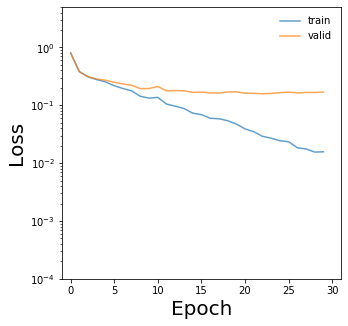

In [29]:
layers = [
    Conv1d(1, 5),
    ReLU(),
    FC(100),
    ReLU(),
    FC(y_train.shape[1]),
    Softmax(),
]

cnn = CNN1dClassifier(layers, n_epoch=30, epoch_interval=3)
%time cnn.fit(X_train[:10000], y_train[:10000], X_val[:5000], y_val[:5000])
calc_accuracy(cnn)
draw_loss(cnn)